# Simulate a frequency selective cannel with OFDM

In this notebook we will modulate and transmit QAM symbols using OFDM. The transmit signal will be sent through a frequency selective channel, modeled as a *tapped delay line* channel. Even though this channel is frequency selective, OFDM make the channel appears flat in each subcarrier, although each subcarrier has a different channel gain that we will need to compensate. This compensasion is equivalent to a 1-tap equalizer and its simplicity is one of the main OFDM advantages.

## Initializations

First we do some initializations and import some packages we will use.

In [2]:
%matplotlib inline

In [22]:
import math
import sys

import numpy as np
from matplotlib import pyplot as plt

from pyphysim import channels
from pyphysim.channels.fading import COST259_RAx, TdlChannel
from pyphysim.channels.fading_generators import JakesSampleGenerator
from pyphysim.modulators import OFDM, PSK, QAM
from pyphysim.modulators.ofdm import OfdmOneTapEqualizer
from pyphysim.util.misc import randn_c
from pyphysim.util.conversion import linear2dB

## Simulation Parameters

In [4]:
M = 16  # Size of the modulation constelation
noise_var = 1e-3
bandwidth = 5e6  # in Hetz
Fd = 10  # Doppler frequency (in Hz)
Ts = 1. / bandwidth  # Sampling interval
fft_size = 1024
num_used_subcarriers = 600
num_ofdm_symbols = 10
# Number of QAM symbols that will be generated
num_symbols = num_ofdm_symbols * num_used_subcarriers
cp_size = 10  # Size of the OFDM cyclic interval (in samples)

## Perform the Simulation

Now we can create the QAM and OFDM objects and generate the transmit signal.

In [5]:
# Creates the required objects
qam = QAM(M)
ofdm = OFDM(fft_size, cp_size, num_used_subcarriers)

# Generate some random data to modulate with QAM
data = np.random.randint(0, M, num_symbols)

# Modulate the data
qam_symbols = qam.modulate(data)

# OFDM Modulate the QAM symbols
ofdm_symbols = ofdm.modulate(qam_symbols)

Let's see the QAM symbols in a scatter plot. Since the symbols were not corrupted yet all symbols should only be one of the 16 possible symbols in the QAM-16 constellation. Also, note that the mean power of the symbols is close to 1.

Mean symbol power: 0.9882666666666667


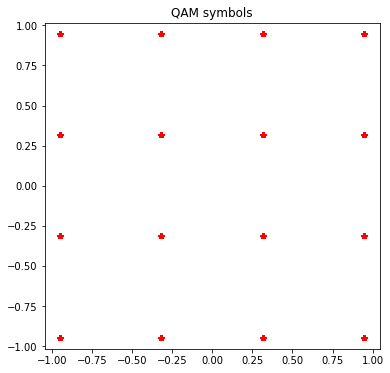

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(np.real(qam_symbols), np.imag(qam_symbols), 'r*')
ax.set_title('QAM symbols')
ax.axis("equal")
# The QAM symbols have an average power equal to 1.0
print("Mean symbol power: {0}".format(np.mean(np.abs(qam_symbols)**2)))
# fig.show()

We can also plot the OFDM modulated data.

Mean symbol power: 0.9732794789288333


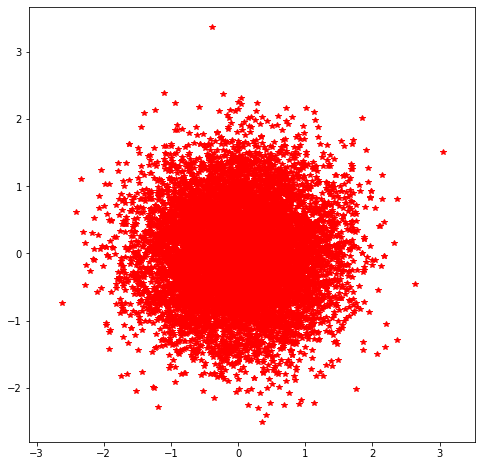

In [7]:
fig2, ax2 = plt.subplots(figsize=(8, 8))
ax2.plot(np.real(ofdm_symbols), np.imag(ofdm_symbols), 'r*')
ax2.axis('equal')

# The power is divided among all subcarriers.
# The whole OFMD has an average power lower then 1.0 due to some energy being spent to transmit the cyclic prefix.
# If you set the cyclic prefix to zero then the average power will be the same as the one computed for
# the QAM symbols before, but that would also means inter symbol interference, since we will transmit in
# a channel with memory
print("Mean symbol power: {0}".format(np.mean(np.abs(ofdm_symbols)**2)))

# fig.show()

In [8]:
# Create a jakes object with 20 rays. This is the fading model that controls how the channel vary in time.
# This will be passed to the TDL channel object.
jakesObj = JakesSampleGenerator(Fd, Ts, L=20)

# Creates the tapped delay line (TDL) channel model, which accounts for the multipath and thus the
# frequency selectivity
tdlchannel = TdlChannel(jakesObj, COST259_RAx)

# Transmit the ofdm modulated signal through the TDL channel
received_ofdm_symbols = tdlchannel.corrupt_data(ofdm_symbols)

# Add random white noise
received_ofdm_symbols += math.sqrt(noise_var) * randn_c(
    received_ofdm_symbols.size)

# OFDM Demodulate received data (the last samples corresponding
# only to channel memory are removed)
ofdm_demodulated_data = ofdm.demodulate(
    received_ofdm_symbols[0:ofdm_symbols.size])

# Reshape the demodulated data to make it easy to extract samples for each individual OFDM symbol
ofdm_demodulated_data = np.reshape(ofdm_demodulated_data,
                                   [-1, num_used_subcarriers],
                                   order='C')

received_ofdm_symbol1 = ofdm_demodulated_data[0]
received_ofdm_symbol2 = ofdm_demodulated_data[1]

## Plot the data of the first 2 received OFDM symbols

Note that it is not correct and does not appear like the QAM symbols we want. The reason is that althouh the channel in each subcarrier is flat, each subcarrier has a different complex gain we still need to correct.

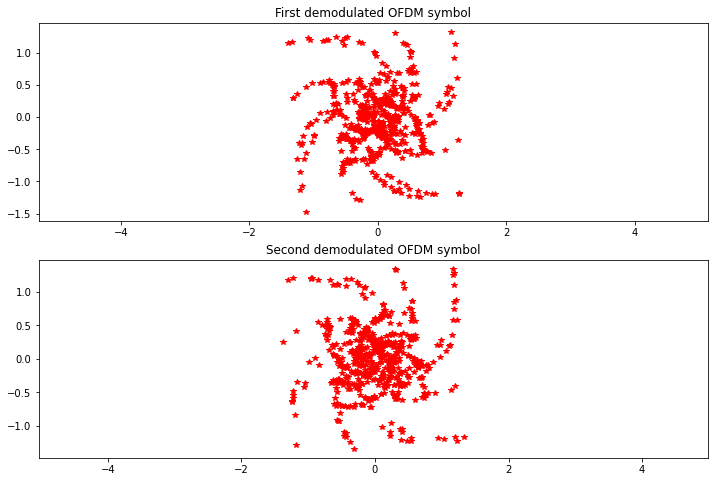

In [9]:
fig3, [ax31, ax32] = plt.subplots(figsize=(12, 8), nrows=2)

ax31.plot(np.real(received_ofdm_symbol1), np.imag(received_ofdm_symbol1), 'r*')
ax31.set_title('First demodulated OFDM symbol')
ax31.axis('equal')

# plt.subplot(2, 1, 2)
ax32.plot(np.real(received_ofdm_symbol2), np.imag(received_ofdm_symbol2), 'r*')
ax32.set_title('Second demodulated OFDM symbol')
ax32.axis('equal')

# fig3.show()

## Perform the one-tap equalization

First we get the frequence response at each subcarrier. This will be sligtly different for each OFDM symbol due to **channel variation in time**. In fact, it varies even during the transmission of a single OFDM symbol, but we are simulating for a low dopper frequency value. We will thus average the frequency response during the transmission of a single OFDM symbol.

Let's plot the average frequency response in different OFDM symbols to visualize the channel variation.

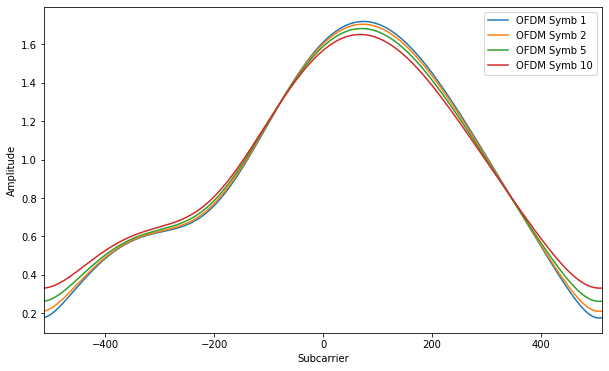

In [10]:
# Plot the channel mean frequency response that the different OFDM symbols perceived
impulse_response = tdlchannel.get_last_impulse_response()
freq_response = impulse_response.get_freq_response(fft_size)
freq_response = np.reshape(freq_response, (fft_size, num_ofdm_symbols, -1))
mean_freq_response = np.mean(freq_response, axis=2)
subcarrier_idx = np.arange(-fft_size // 2, fft_size // 2)
fig4, ax4 = plt.subplots(figsize=(10, 6))
# plt.figure()
ax4.plot(subcarrier_idx, np.abs(mean_freq_response[:, 0]))
ax4.plot(subcarrier_idx, np.abs(mean_freq_response[:, 2]))
ax4.plot(subcarrier_idx, np.abs(mean_freq_response[:, 5]))
ax4.plot(subcarrier_idx, np.abs(mean_freq_response[:, -1]))
ax4.legend(['OFDM Symb 1', 'OFDM Symb 2', 'OFDM Symb 5', 'OFDM Symb 10'])
ax4.set_xlabel('Subcarrier')
ax4.set_ylabel('Amplitude')
ax4.set_xlim([-fft_size // 2, fft_size // 2])
# fig4.show()

Now let's perform the one-tap equalization. For that we define the equalize function below.

In [11]:
# This function can perform the one-tap-equalization
def equalize(ofdm_obj, data, impulse_response):
    freq_response = impulse_response.get_freq_response(fft_size)

    print(freq_response.shape)
    # Reshape and get the average frequency response for all samples in each OFDM symbol
    freq_response = np.reshape(freq_response, (fft_size, num_ofdm_symbols, -1))
    mean_freq_response = np.mean(freq_response, axis=2)

    # Apply the fftshift so that we have the frequency response at the correct locations (natural order)
    #mean_freq_response = np.fft.fftshift(mean_freq_response, axes=0)
    mean_freq_response_T = mean_freq_response.T

    num_unused_subcarriers = fft_size - num_used_subcarriers

    equalized_ofdm_demodulated_data = data / \
        mean_freq_response_T[:, ofdm_obj._get_used_subcarrier_indexes_proper()]
    #mean_freq_response_T[:, num_unused_subcarriers//2:-num_unused_subcarriers//2]

    equalized_ofdm_demodulated_data = equalized_ofdm_demodulated_data.flatten()
    return equalized_ofdm_demodulated_data

In [12]:
# Note that in pyphysim we have a class that can perform this one-tap-equalization as well
ofdm_equalizer = OfdmOneTapEqualizer(ofdm)
equalized_ofdm_demodulated_data = ofdm_equalizer.equalize_data(
    ofdm_demodulated_data, impulse_response)

In the plot we can clearly see that now we have the correct QAM symbols (corrupted by the white noise).

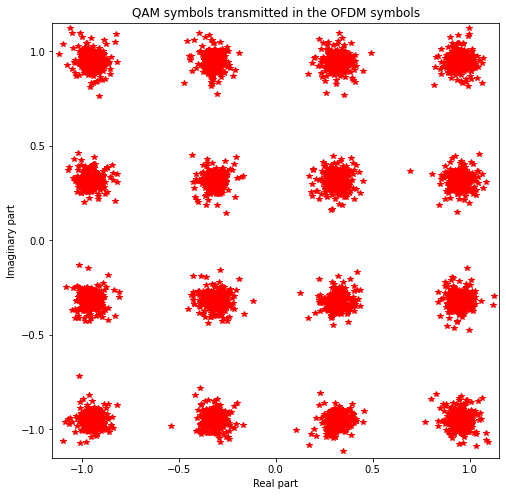

In [13]:
plt.figure(figsize=(8, 8))
plt.plot(np.real(equalized_ofdm_demodulated_data),
         np.imag(equalized_ofdm_demodulated_data), 'r*')
plt.title('QAM symbols transmitted in the OFDM symbols')
plt.xlim([-1.15, 1.15])
plt.ylim([-1.15, 1.15])
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.show()

Let's compute the symbol error rate, but note that this is just of a single realization. To get a proper value you need to implement a Monte Carlo simulation.

In [14]:
received_data = qam.demodulate(equalized_ofdm_demodulated_data)

# Compare received data with transmitted data
ser = 1 - np.sum(data == received_data) / data.size
print("Symbol Error Rate: {0}".format(ser))

Symbol Error Rate: 0.0


# Monte Carlo SImulation to get get tge symbol error rate

<span style="color:red;">TODO</span>: Validate the results here comparing results with some paper in the literature

In [15]:
%reset -f

In [17]:
import math
import sys

import numpy as np
from matplotlib import pyplot as plt

from pyphysim import channels
from pyphysim.channels.fading import COST259_RAx, TdlChannel
from pyphysim.channels.fading_generators import JakesSampleGenerator
from pyphysim.modulators import OFDM, PSK, QAM
from pyphysim.modulators.ofdm import OfdmOneTapEqualizer
from pyphysim.simulations import Result, SimulationResults, SimulationRunner
from pyphysim.util.conversion import dB2Linear
from pyphysim.util.misc import count_bit_errors, randn_c

In [18]:
class OfdmTdlSimulator(SimulationRunner):

    def __init__(self, SINR_dB_values):
        super().__init__()

        self.rep_max = 5000

        # Add the simulation parameters to the `params` attribute.
        self.params.add('SNR_db', SINR_dB_values)
        self.params.set_unpack_parameter('SNR_db')

        # Fixed parameters (we could add to `self.params`, but we will just save them as attributes)
        self._bandwidth = 5e6  # Bandwidth (in Hetz)
        self._Fd = 10.0  # Doppler frequency (in Hetz)
        self._fft_size = 1024
        self._num_used_subcarriers = 600
        self._num_ofdm_symbols = 10
        self._cp_size = 10  # Size of the OFDM cyclic interval (in samples)
        self._modulator = QAM(16)

        # Number of symbols generated for this realization
        self._num_symbols = 1000

        # Set a nice message for the progressbar
        self.progressbar_message = "Simulating for SNR {SNR_db}"

        # Used in the implementation of `_keep_going` method. This is the maximum numbers of symbol
        # errors we allow before `_run_simulation` is stoped for a given configuration
        self._max_symbol_errors = 1. / 100. * self._num_symbols * self.rep_max

    def _keep_going(self, current_params, current_sim_results, current_rep):
        # Note that we have added a "symbol_errors" result in `_run_simulation` to use here

        # Get the last value in the "symbol_errors" results list, which corresponds to the current configuration
        cumulated_symbol_errors \
            = current_sim_results['num_symbol_errors'][-1].get_result()
        return cumulated_symbol_errors < self._max_symbol_errors

    def _run_simulation(self, current_parameters):
        # Creates the required objects
        ofdm = OFDM(self._fft_size, self._cp_size, self._num_used_subcarriers)

        # Generate some random data to modulate with QAM
        data = np.random.randint(0, self._modulator.M, self._num_symbols)

        # Modulate the data
        qam_symbols = self._modulator.modulate(data)

        # OFDM Modulate the QAM symbols
        ofdm_symbols = ofdm.modulate(qam_symbols)

        # Create a jakes object with 20 rays. This is the fading model that controls how the channel vary in time.
        # This will be passed to the TDL channel object.
        Ts = 1. / self._bandwidth  # Sampling interval
        jakesObj = JakesSampleGenerator(self._Fd, Ts, L=20)

        # Creates the tapped delay line (TDL) channel model, which accounts for the multipath and thus the
        # frequency selectivity
        tdlchannel = TdlChannel(jakesObj, COST259_RAx)

        # Transmit the ofdm modulated signal through the TDL channel
        received_ofdm_symbols = tdlchannel.corrupt_data(ofdm_symbols)

        # Add random white noise
        sinr_dB = current_parameters['SNR_db']
        snr_linear = dB2Linear(
            sinr_dB)  # Find the noise power from the SNR value (in dB)
        noise_var = 1 / snr_linear
        received_ofdm_symbols += math.sqrt(noise_var) * randn_c(
            received_ofdm_symbols.size)

        # OFDM Demodulate received data (the last samples corresponding
        # only to channel memory are removed)
        ofdm_demodulated_data = ofdm.demodulate(
            received_ofdm_symbols[0:ofdm_symbols.size])

        # Reshape the demodulated data to make it easy to extract samples for each individual OFDM symbol
        ofdm_demodulated_data = np.reshape(ofdm_demodulated_data,
                                           [-1, self._num_used_subcarriers],
                                           order='C')

        # Get the channel impulse response -> in practice you would get this through channel estimation
        impulse_response = tdlchannel.get_last_impulse_response()

        # Perform the one-tap equalization
        ofdm_equalizer = OfdmOneTapEqualizer(ofdm)
        equalized_ofdm_demodulated_data = ofdm_equalizer.equalize_data(
            ofdm_demodulated_data, impulse_response)

        equalized_ofdm_demodulated_data = equalized_ofdm_demodulated_data[:self.
                                                                          _num_symbols]

        # Demodulate and compute the symbol error rate
        received_data = self._modulator.demodulate(
            equalized_ofdm_demodulated_data)
        num_symbol_errors = np.sum(data != received_data)

        num_bit_errors = count_bit_errors(data, received_data)

        simResults = SimulationResults()
        simResults.add_new_result("symbol_error_rate",
                                  Result.RATIOTYPE,
                                  value=num_symbol_errors,
                                  total=data.size)
        simResults.add_new_result("num_symbol_errors",
                                  Result.SUMTYPE,
                                  value=num_symbol_errors)
        simResults.add_new_result("num_bit_errors",
                                  Result.SUMTYPE,
                                  value=num_bit_errors)
        simResults.add_new_result("bit_error_rate",
                                  Result.RATIOTYPE,
                                  value=num_bit_errors,
                                  total=int(np.log2(self._modulator.M)) *
                                  data.size)

        return simResults

In [19]:
SNR_db = np.linspace(5, 30, 11)
runner = OfdmTdlSimulator(SNR_db)

In [20]:
runner.simulate()

------------- Current Variation: 1/11 ------------
[**********************100%**********************]  Simulating for SNR 5.0
------------- Current Variation: 2/11 ------------
[**********************100%**********************]  Simulating for SNR 7.5
------------- Current Variation: 3/11 ------------
[**********************100%**********************]  Simulating for SNR 10.0
------------- Current Variation: 4/11 ------------
[**********************100%**********************]  Simulating for SNR 12.5
------------- Current Variation: 5/11 ------------
[**********************100%**********************]  Simulating for SNR 15.0
------------- Current Variation: 6/11 ------------
[**********************100%**********************]  Simulating for SNR 17.5
------------- Current Variation: 7/11 ------------
[**********************100%**********************]  Simulating for SNR 20.0
------------- Current Variation: 8/11 ------------
[**********************100%**********************]  Simulating

Text(0.5, 1.0, 'BER for OFDM with 16-QAM')

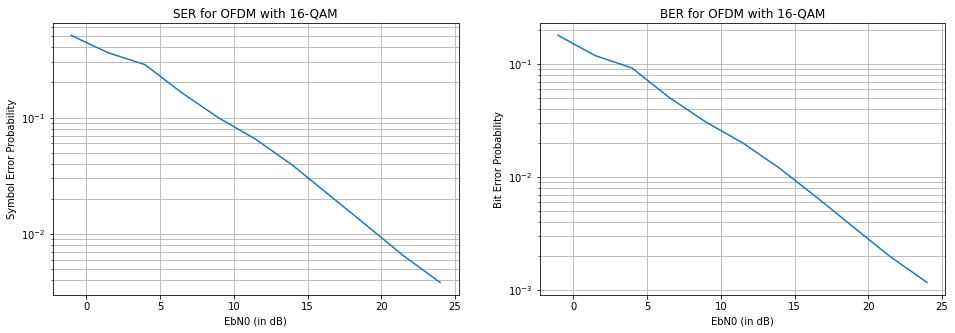

In [23]:
fig5, [ax51, ax52] = plt.subplots(figsize=(16, 5), ncols=2)
ax51.semilogy(SNR_db - linear2dB(4),
              runner.results.get_result_values_list("symbol_error_rate"))
ax51.set_ylabel("Symbol Error Probability")
ax51.set_xlabel("EbN0 (in dB)")
ax51.grid(True, which='both')
ax51.set_title(f"SER for OFDM with {runner._modulator.M}-QAM")

ax52.semilogy(SNR_db - linear2dB(4),
              runner.results.get_result_values_list("bit_error_rate"))
ax52.set_ylabel("Bit Error Probability")
ax52.set_xlabel("EbN0 (in dB)")
ax52.grid(True, which='both')
ax52.set_title(f"BER for OFDM with {runner._modulator.M}-QAM")

# fig.show()

In [ ]:
# Check here
# https://onlinelibrary.wiley.com/doi/full/10.1002/wcm.1135